In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
# read data
data = pd.read_csv('ecommerceDataset.csv')

In [ ]:
df_commerce = pd.DataFrame()
df_commerce['text'] = data.iloc[:, -1]
df_commerce['labels'] = data.iloc[:, 0:1]
df_commerce.head()


,text,labels
0,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
1,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
2,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
3,Incredible Gifts India Wooden Happy Birthday U...,Household
4,Pitaara Box Romantic Venice Canvas Painting 6m...,Household


In [ ]:
df = df_commerce.copy()
df['targets'] = df['labels'].astype("category").cat.codes

In [ ]:
# number of classes
K = df['targets'].max() + 1
K

4

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3)

33277    Girls Shopping Plain Stylish Cotton Leggings f...
17226    Noctronique Metal and Wood Carpenter Carbide T...
35725    US Polo Association Men's Striped Regular Fit ...
2908     Pigeon Uber Cool 12776 2.5-Litre Air Cooler (M...
5831     Ahmedabad Cotton 144 TC Cotton Bedsheet with 2...
                               ...                        
9951     Joyo Plastic Cutlery Organizer, 5 Compartments...
8950     Quace Waterproof Auto on/off Flickering Solar ...
40531    Silicon Power 8GB DDR3 PC3L-12800 1600MHz 204-...
27160    Civil Engineering Vol- 1 Civil Engineering Vol- 1
8266     Cello Novelty Shoe Rack (Ice Brown) Color:Ice ...
Name: text, Length: 15128, dtype: object

In [ ]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
# tokenizer.fit_on_texts(df_train['text'])
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
# sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 81988 unique tokens.


In [ ]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (35296, 5718)


In [ ]:
sequences_test = tokenizer.texts_to_sequences(df_test['text'].iloc[:5000])

data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (5000, 5718)


In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to convert the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)


In [ ]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['targets'],
  epochs=10,
  validation_data=(data_test, df_test['targets'].iloc[:5000])
)

Training model...
Epoch 1/10
1103/1103 [==============================] - 164s 148ms/step - loss: 0.1989 - accuracy: 0.9476 - val_loss: 0.1675 - val_accuracy: 0.9564
Epoch 2/10
1103/1103 [==============================] - 162s 147ms/step - loss: 0.1557 - accuracy: 0.9577 - val_loss: 0.1541 - val_accuracy: 0.9606
Epoch 3/10
1103/1103 [==============================] - 162s 147ms/step - loss: 0.1327 - accuracy: 0.9644 - val_loss: 0.1499 - val_accuracy: 0.9630
Epoch 4/10
1103/1103 [==============================] - 159s 145ms/step - loss: 0.1168 - accuracy: 0.9678 - val_loss: 0.1490 - val_accuracy: 0.9624
Epoch 5/10
1103/1103 [==============================] - 162s 147ms/step - loss: 0.1031 - accuracy: 0.9715 - val_loss: 0.1607 - val_accuracy: 0.9606
Epoch 6/10
1103/1103 [==============================] - 162s 147ms/step - loss: 0.0927 - accuracy: 0.9748 - val_loss: 0.1539 - val_accuracy: 0.9616
Epoch 7/10
1103/1103 [==============================] - 162s 146ms/step - loss: 0.0839 - accur

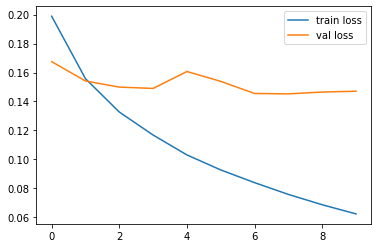

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

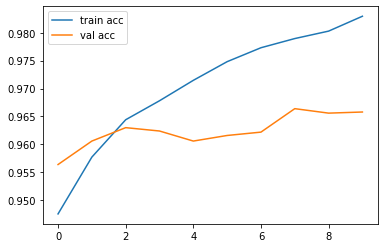

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();